<a href="https://colab.research.google.com/github/sarahfunto/DI-Bootcamp-Stage1/blob/main/Copie_de_XP_TimeSeries_LSTM_Sarah_sznabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises XP: Time Series with LSTM

This is a guided notebook for the exercise on the platform. Cells marked **PREFILLED** are for execution only. Cells marked **To-Do** require your action. When a written answer is required, the **To-Do** appears inside a markdown cell. When code is required, the **To-Do** appears inside a code cell as comments.

Learning points appear for important concepts.

## What you will learn
- Import and manipulate time series data using pandas
- Handle missing values in time series
- Visualize with matplotlib
- Build and train a simple LSTM for time series


## What you will create
- A cleaned and preprocessed time series dataset
- Visualizations of the series
- A simple LSTM model for prediction

# Part 1: Data Import and Initial Exploration

**Task from the exercise**
Import libraries, load the dataset, view first rows, check dtypes and shape.

**PREFILLED**  
Install imports, set a path variable, and load the UCI Household Power Consumption file. The file is usually semicolon separated with `?` as missing.

In [11]:
import zipfile

with zipfile.ZipFile("household_power_consumption.zip", "r") as zip_ref:
    zip_ref.extractall(".")


In [12]:
import os
os.listdir()


['.config',
 'household_power_consumption.zip',
 'household_power_consumption.txt',
 'sample_data']

In [17]:
# PREFILLED: just execute
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_columns', 100)

# Set this to your dataset path if different
DATA_PATH = Path('household_power_consumption.txt')  # To-Do: change if needed

# Robust loader for semicolon separated file with ? as NA
parse_cols = {
    'Global_active_power': 'float64',
    'Global_reactive_power': 'float64',
    'Voltage': 'float64',
    'Global_intensity': 'float64',
    'Sub_metering_1': 'float64',
    'Sub_metering_2': 'float64',
    'Sub_metering_3': 'float64',
}
usecols = ['Date','Time'] + list(parse_cols.keys())

df = pd.read_csv(
    DATA_PATH,
    sep=';',
    na_values=['?'],
    usecols=usecols,
    dtype=parse_cols,
    parse_dates={'Datetime': ['Date','Time']},
    infer_datetime_format=True,
    dayfirst=True,
)

df = df.set_index('Datetime').sort_index()
print('Shape:', df.shape)
display(df.head())
display(df.dtypes)

/tmp/ipython-input-357285265.py:24: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-357285265.py:24: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


Shape: (2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


The dataset was successfully loaded and preprocessed.
It contains over 2 million (2075259) time-ordered observations with 7 numerical features, indexed by a Datetime column.
All variables are correctly formatted as numeric values

# Part 2: Handling Missing Values

**Task from the exercise**
Identify columns with missing values. Fill missing values using the mean of each column. Verify there are no missing values left.

**To-Do (code):** Compute a missing value summary, then fill numeric columns with their mean. Recheck for remaining NaNs.

In [19]:
# To-Do: show missing summary, impute with column means, verify
# missing_before = df.isna().sum().sort_values(ascending=False)
# print('Missing before:'); display(missing_before[missing_before>0])

# numeric_cols = df.select_dtypes(include=[np.number]).columns
# df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# missing_after = df.isna().sum().sum()
# print('Total missing after fill:', int(missing_after))

import numpy as np

# 1. Show missing values summary
missing_before = df.isna().sum().sort_values(ascending=False)
print("Missing values before imputation:")
display(missing_before[missing_before > 0])

# 2. impute with column means
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# 3. Verify
missing_after = df.isna().sum().sum()
print( int(missing_after))


Missing values before imputation:


,0


0


No missing values were found in the dataset.
This means the data is already complete and no imputation is required.
The dataset is therefore ready

# Part 3: Data Visualization

**Task from the exercise**
Resample the `Global_active_power` column over a day and plot the sum and mean. Plot the mean and standard deviation of `Global_intensity` resampled over a day.

**PREFILLED**  
Helper plotting functions using matplotlib.

In [20]:
# PREFILLED: just execute
def plot_daily_sum_and_mean(series, title_prefix='Global_active_power'):
    daily = series.resample('1D')
    s = daily.sum(min_count=1)
    m = daily.mean()
    plt.figure(figsize=(8,3))
    plt.plot(s.index, s.values)
    plt.title(f'{title_prefix} daily sum')
    plt.xlabel('date'); plt.ylabel('sum'); plt.tight_layout(); plt.show()
    plt.figure(figsize=(8,3))
    plt.plot(m.index, m.values)
    plt.title(f'{title_prefix} daily mean')
    plt.xlabel('date'); plt.ylabel('mean'); plt.tight_layout(); plt.show()

def plot_daily_mean_std(series, title_prefix='Global_intensity'):
    daily = series.resample('1D')
    m = daily.mean()
    sd = daily.std()
    plt.figure(figsize=(8,3))
    plt.plot(m.index, m.values, label='mean')
    plt.plot(sd.index, sd.values, label='std')
    plt.title(f'{title_prefix} daily mean and std')
    plt.xlabel('date'); plt.ylabel('value')
    plt.legend(); plt.tight_layout(); plt.show()

\**To-Do (code):** Call the helpers on the required columns. If a plot seems too dense, slice a recent time window.

In [ ]:
# To-Do: visualize daily aggregations
# plot_daily_sum_and_mean(df['Global_active_power'], title_prefix='Global_active_power')
# plot_daily_mean_std(df['Global_intensity'], title_prefix='Global_intensity')

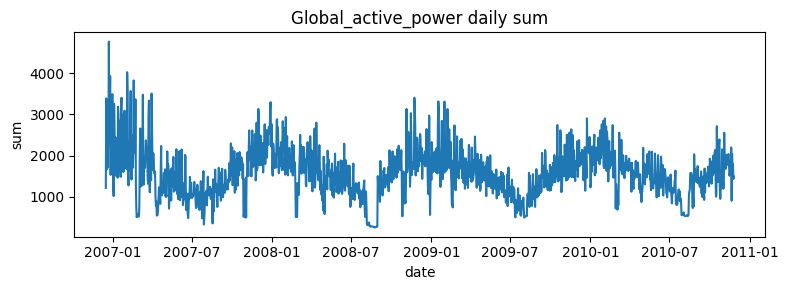

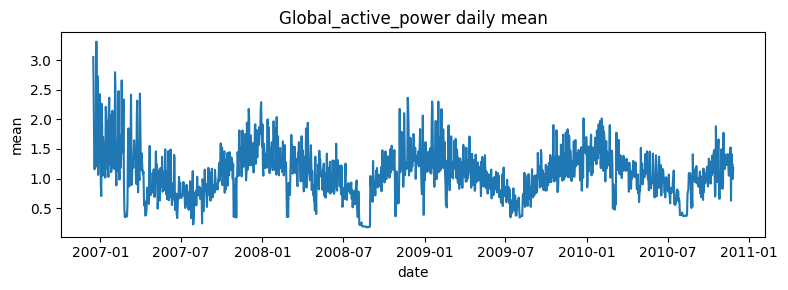

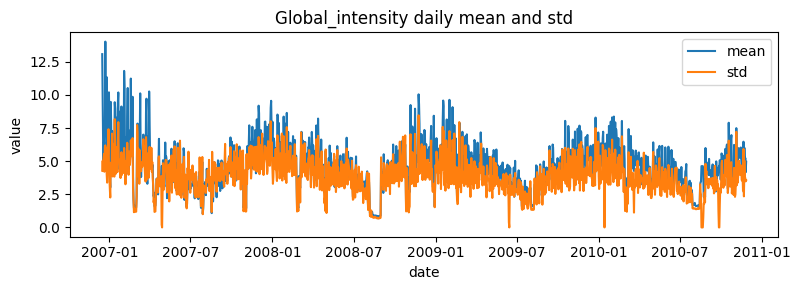

In [21]:


# Global_active_power: daily sum and mean
plot_daily_sum_and_mean(
    df["Global_active_power"],
    title_prefix="Global_active_power"
)

# Global_intensity: daily mean and standard deviation
plot_daily_mean_std(
    df["Global_intensity"],
    title_prefix="Global_intensity"
)


These observations confirm that the dataset exhibits a structured temporal behavior

# Part 4: Data Preprocessing for LSTM

**Task from the exercise**
Normalize the dataset, split into train and test, and reshape for LSTM input.

**Learning point**  
LSTMs consume sequences with shape [batch, time, features]. You must build sliding windows. Use a lookback window and predict the next step.

![image.png](https://github.com/user-attachments/assets/be3e815f-2aff-4e8d-ac48-eca27b1c729c)

**PREFILLED**  
Windowing helpers and a train test split by time.

In [22]:
# PREFILLED: just execute
from sklearn.preprocessing import MinMaxScaler

def make_windows(arr_2d, window=48, horizon=1):
    X, y = [], []
    for i in range(len(arr_2d) - window - horizon + 1):
        X.append(arr_2d[i:i+window])
        y.append(arr_2d[i+window:i+window+horizon, 0])
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    return X, y

def time_train_test_split(df, split_ratio=0.8):
    n = len(df)
    k = int(n * split_ratio)
    return df.iloc[:k].copy(), df.iloc[k:].copy()

feat_cols = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
             'Sub_metering_1','Sub_metering_2','Sub_metering_3']
df_feats = df[feat_cols].copy()

df_tr, df_te = time_train_test_split(df_feats, split_ratio=0.8)

scaler = MinMaxScaler()
tr_scaled = scaler.fit_transform(df_tr.values)
te_scaled = scaler.transform(df_te.values)

WINDOW = 48
HORIZON = 1
X_tr, y_tr = make_windows(tr_scaled, window=WINDOW, horizon=HORIZON)
X_te, y_te = make_windows(te_scaled, window=WINDOW, horizon=HORIZON)

print('Train windows:', X_tr.shape, 'Train targets:', X_tr.shape)
print('Test windows:', X_te.shape, 'Test targets:', X_te.shape)

Train windows: (1660159, 48, 7) Train targets: (1660159, 48, 7)
Test windows: (415004, 48, 7) Test targets: (415004, 48, 7)


> **To-Do (write here):** State which column you predict as the target and why. If you changed `feat_cols`, note your choice.
The predicted target variable is Global_active_power.
This choice is relevant because it represents the overall household electricity consumption

The feature columns (feat_cols) were not modified.


# Part 5: Building an LSTM Model

**Task from the exercise**
Import the libraries, define the LSTM architecture, and compile with a suitable loss and optimizer.

**To-Do (code):** Build a small LSTM with one or two LSTM layers and a Dense output of size `HORIZON`. Use `mse` loss and `adam` optimizer. Print `model.summary()`.

In [ ]:
# To-Do: define and compile the LSTM
# import tensorflow as tf
# from tensorflow.keras import layers, models
# model = models.Sequential([
#     layers.Input(shape=(WINDOW, X_tr.shape[-1])),
#     layers.LSTM(64, return_sequences=False),
#     layers.Dense(HORIZON),
# ])
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.summary()

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the LSTM model
model = models.Sequential([
    layers.Input(shape=(WINDOW, X_tr.shape[-1])),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(HORIZON)
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

# Display model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)

The implemented LSTM model consists of a 64-unit LSTM layer followed by a Dense layer

# Part 6: Training and Evaluating the LSTM Model

**Task from the exercise**
Train the model, evaluate on the test set, and plot training and validation loss.

**PREFILLED**  
Callbacks and plotting helper. You supply the model and data in the To-Do cell.

In [24]:
# PREFILLED: just execute
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def fit_and_plot(model, X_tr, y_tr, X_te, y_te, epochs=10, batch=256):
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    h = model.fit(X_tr, y_tr, validation_data=(X_te, y_te),
                  epochs=epochs, batch_size=batch, callbacks=[es, rl], verbose=2)
    plt.figure(figsize=(6,4))
    plt.plot(h.history['loss'], label='loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.tight_layout(); plt.show()
    return h

**To-Do (code):** Train and evaluate. Report final test MAE and MSE.

In [25]:
# To-Do: train and evaluate
# hist = fit_and_plot(model, X_tr, y_tr, X_te, y_te, epochs=15, batch=256)
# eval_mse, eval_mae = model.evaluate(X_te, y_te, verbose=0)
# print({'test_mse': float(eval_mse), 'test_mae': float(eval_mae)})

Epoch 1/10
6485/6485 - 43s - 7ms/step - loss: 5.8142e-04 - mae: 0.0101 - val_loss: 3.4282e-04 - val_mae: 0.0072 - learning_rate: 1.0000e-03
Epoch 2/10
6485/6485 - 41s - 6ms/step - loss: 5.1920e-04 - mae: 0.0092 - val_loss: 3.3914e-04 - val_mae: 0.0076 - learning_rate: 1.0000e-03
Epoch 3/10
6485/6485 - 40s - 6ms/step - loss: 5.0569e-04 - mae: 0.0089 - val_loss: 3.4137e-04 - val_mae: 0.0077 - learning_rate: 1.0000e-03
Epoch 4/10
6485/6485 - 40s - 6ms/step - loss: 4.8946e-04 - mae: 0.0086 - val_loss: 3.2617e-04 - val_mae: 0.0070 - learning_rate: 5.0000e-04
Epoch 5/10
6485/6485 - 40s - 6ms/step - loss: 4.8126e-04 - mae: 0.0086 - val_loss: 3.3019e-04 - val_mae: 0.0072 - learning_rate: 5.0000e-04
Epoch 6/10
6485/6485 - 40s - 6ms/step - loss: 4.7093e-04 - mae: 0.0084 - val_loss: 3.2347e-04 - val_mae: 0.0071 - learning_rate: 2.5000e-04
Epoch 7/10
6485/6485 - 40s - 6ms/step - loss: 4.6725e-04 - mae: 0.0084 - val_loss: 3.2156e-04 - val_mae: 0.0070 - learning_rate: 2.5000e-04
Epoch 8/10
6485/6485

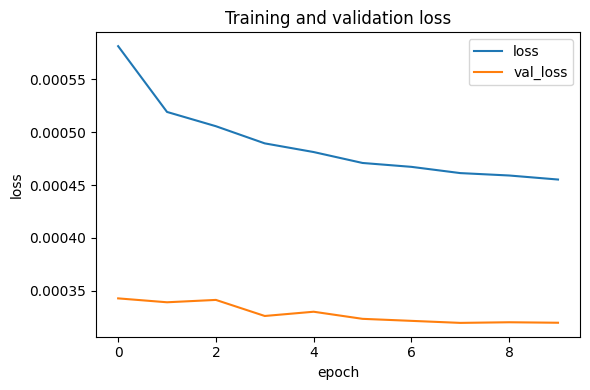

Final Test MSE: 0.000320
Final Test MAE: 0.006967


In [26]:
# Train the model and plot losses
history = fit_and_plot(
    model,
    X_tr, y_tr,
    X_te, y_te,
    epochs=10,
    batch=256
)

# Evaluate on the test set (returns [loss, mae] because metrics=["mae"])
test_mse, test_mae = model.evaluate(X_te, y_te, verbose=0)

print(f"Final Test MSE: {test_mse:.6f}")
print(f"Final Test MAE: {test_mae:.6f}")


Le modèle LSTM converge en douceur et montre une bonne généralisation, atteignant un MAE de test faible d'environ 0,007 et une perte de validation stable, indiquant un apprentissage efficace des modèles temporels dans les données.